In [33]:
K <- 3           # no. of clusters
MEAN_EACH <- 500 # mean no. of points in each cluster
SD_EACH <- 200   # sd. of cluster size

In [34]:
generate.params <- function(n, mn, mx) {
  ms <- runif(n, mn, mx)
  sds <- runif(n, mn / 5, mx / 5)
  list(m=ms, sd=sds)
}

In [35]:
params = generate.params(K, 0, 10)
params

$m
[1] 1.4959326 0.1983332 9.7302084

$sd
[1] 0.5101543 1.7126961 0.9489465

In [36]:
generate.clusters <- function(params) {
  ms <- params$m
  sds <- params$sd
  k <- length(ms)
  x <- numeric()
  assignments <- numeric()
  for (clust in 1:k) {
    n.clust <- max(rnorm(1,MEAN_EACH, SD_EACH), 25)
    xs <- rnorm(n.clust, ms[clust], sds[clust])
    x <- c(x, xs)
    assignments <- c(assignments, rep(clust, n.clust))
  }
  data.frame(x=x, k=assignments)
}

In [37]:
clust <- generate.clusters(params)
tail(clust)

,x,k
1306,9.921700,3
1307,9.644117,3
1308,11.393265,3
1309,9.832353,3
1310,9.488083,3
1311,9.629153,3


In [38]:
table(clust$k)


  1   2   3 
499 618 194 

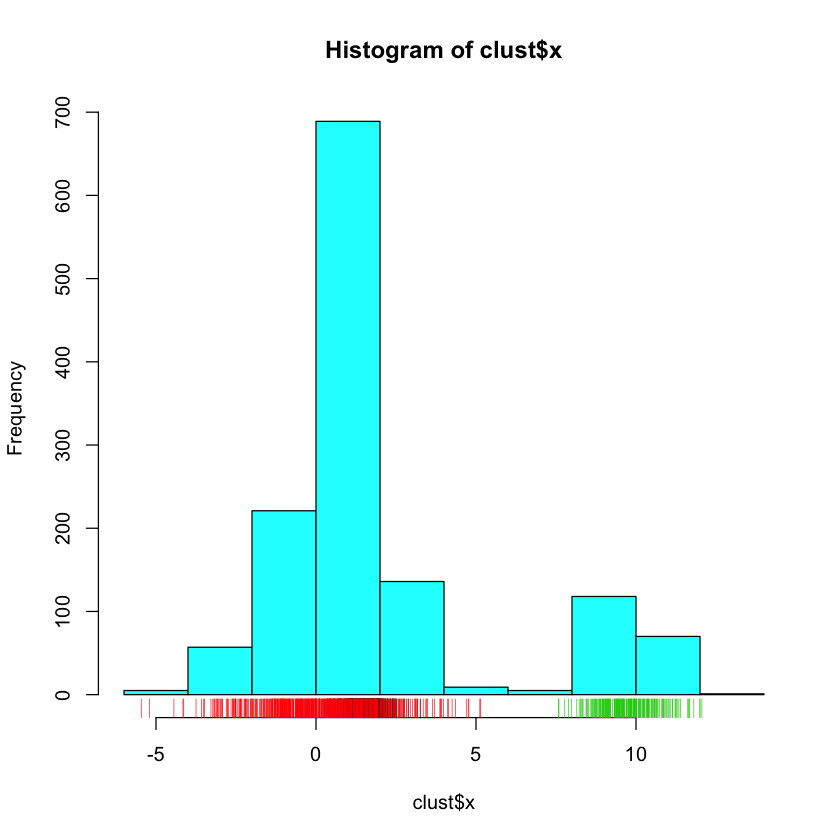

In [39]:
hist(clust$x, col=5)
for (i in 1:K) {
  rug(clust[clust$k == i, 'x'], col=i)
}

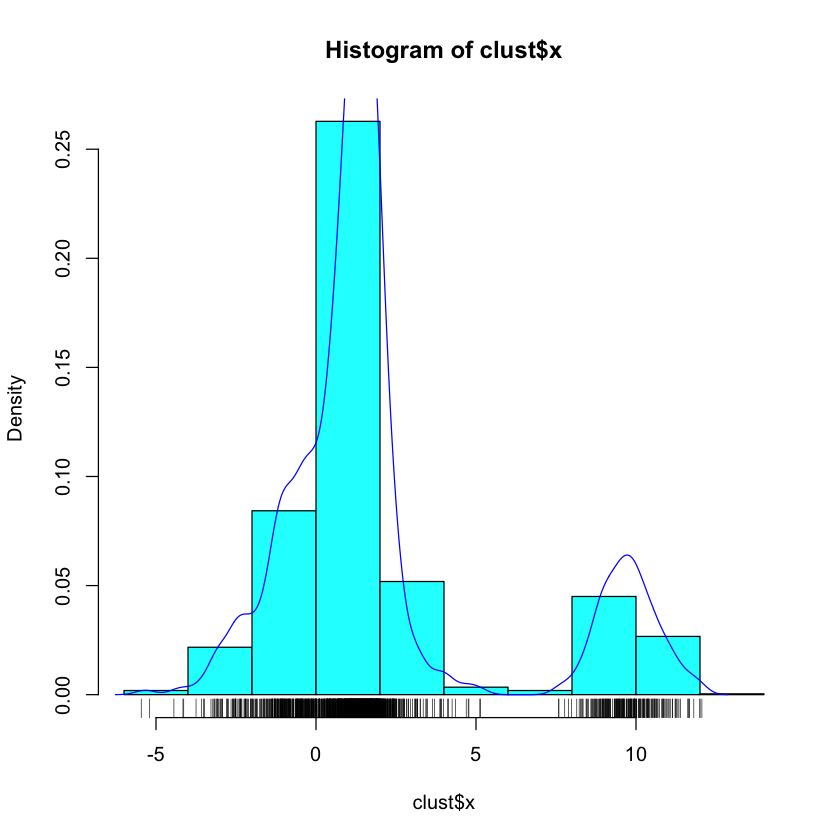

In [40]:
# but without knowing in advance, we'd see this:
hist(clust$x, col=5, freq=F)
rug(clust$x)
lines(density(clust$x), col=4)

### EM Algorithm
1. Predetermine no. of clusters to check
2. Assign all points to a cluster (randomly or otherwise)

In [41]:
random.init.clusters <- function(clust, k) {
  clust$assignments <- sample(clust$k)
  clust
}

In [42]:
quantile.init.clusters <- function(clust, k) {
  n <- nrow(clust)
  clust <- clust[order(clust$x), ]
  # Divide classes evenly; [1:n] in case rounding error adds an
  # extra value
  clust$assignments <- c(rep(1:k, each=round(n/3)), k)[1:n] 
  clust
}

In [43]:
init.clusters <- function(clust, k, method=c('random', 'quantile')) {
  if (method == 'quantile') {
    f <- quantile.init.clusters
  } else { # other methods could go here; random as final fallback
    if (method != 'random') {
      cat('Initialization method not recognized. Using "random".\n')
    }
    f <- random.init.clusters
  }
  f(clust, k)
}

There may be even better ways to initialize, and I encourage you to experiment.  For example:
- Evenly partitioning the search space
- Using K-means to initialize
- Using the peaks of kernel-density estimators

In [44]:
#INIT_METHOD <- 'random' 
INIT_METHOD <- 'quantile'
clust <- init.clusters(clust, K, INIT_METHOD)
head(clust)

,x,k,assignments
997,-5.461411,2,1
785,-5.197476,2,1
925,-4.440322,2,1
797,-4.157585,2,1
575,-4.133210,2,1
535,-3.749063,2,1


In [45]:
table(clust$assignments)


  1   2   3 
437 437 437 

In [46]:
plot.clusters <- function(clust) {
  hist(clust$x, col=5)
  for (i in 1:max(clust$k)) {
    rug(clust[clust$assignments == i, 'x'], col=i)
  }
}

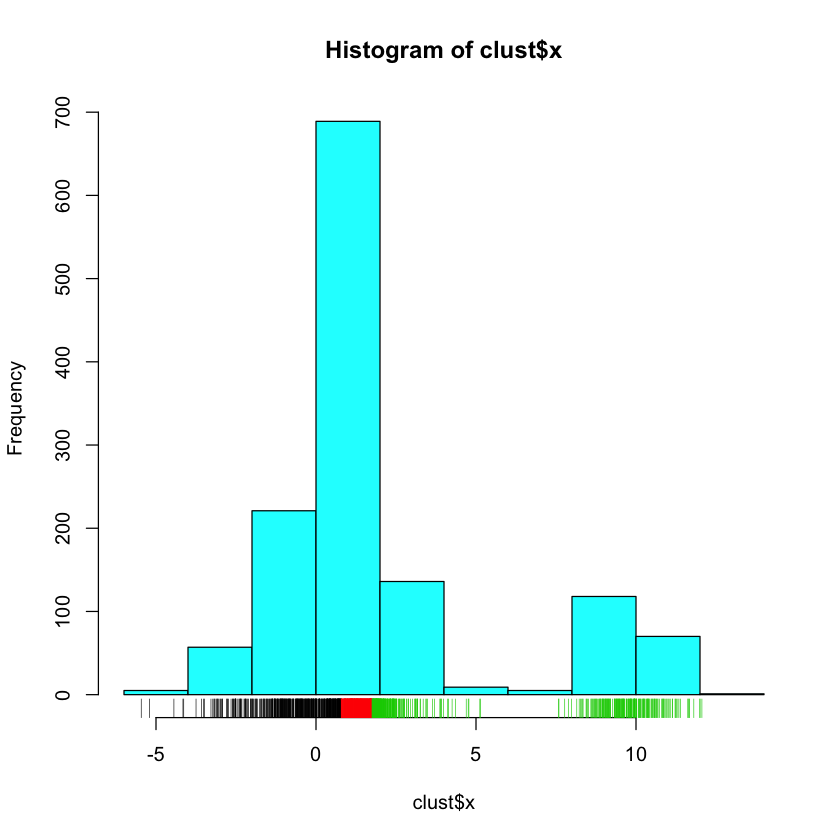

In [47]:
plot.clusters(clust)

3. Given the current assignments, estimate gaussian parameters

In [48]:
get.params.from.assignments <- function(clust, plt=T) {
  ks <- max(clust$assignments)
  mus <- numeric(ks)
  sigmas <- numeric(ks)
  for (k in 1:ks) {
    xs <- clust[clust$assignments == k, 'x']
    mus[k] <- mean(xs)
    sigmas[k] <- sd(xs)
  }
    
  # in the event that some k is excluded b/c of no ownership, randomly
  # reinitialize its parameters to maintain the desired no. of clusters
  if (length(is.na(mus))) {
    mus[is.na(mus)] <- runif(length(sum(is.na(mus))), 0, 10)
    sigmas[is.na(sigmas)] <- runif(length(sum(is.na(sigmas))), 0, 1)        
  }
    
  if (plt) {
    hist(clust$x, col=5, freq=F)
    xv <- seq(min(clust$x), max(clust$x), length=100)
    for (k in 1:ks) {
      rug(clust[clust$assignments == k, 'x'], col=k)
      lines(xv, dnorm(xv, mus[k], sigmas[k]), col=k)
    }
    legend('topleft', 
           lty=1, 
           col=1:k, 
           legend=1:k, 
           title='Cluster', 
           bty='n')
  }
  list(mus=mus, sigmas=sigmas)
}

$mus
[1] -0.6459659  1.3036475  5.6262704

$sigmas
[1] 1.1610392 0.2731292 3.7835625

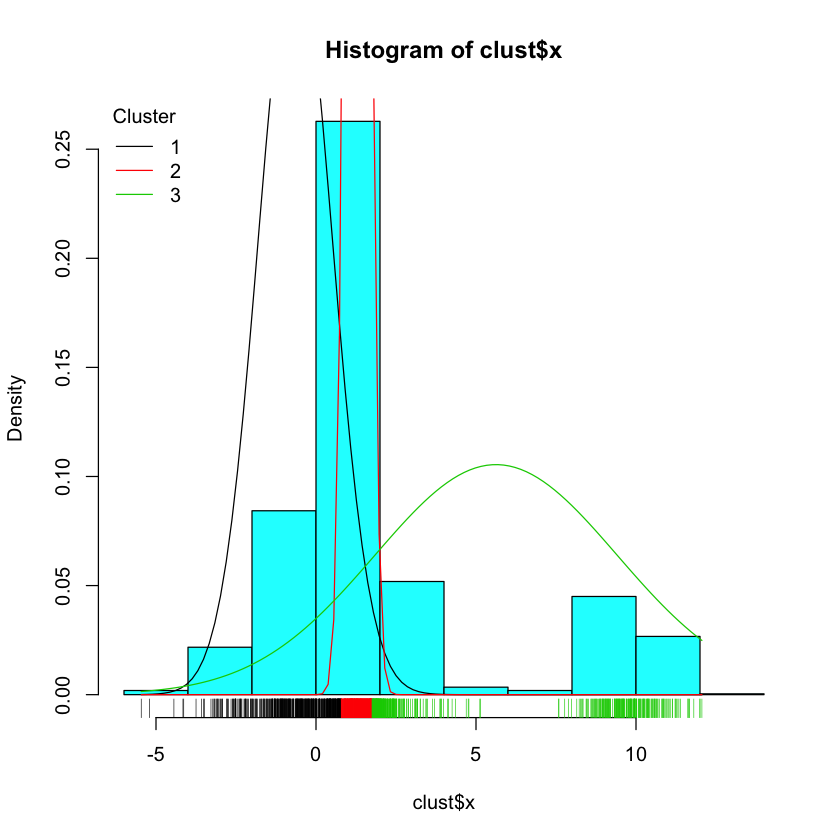

In [49]:
best.params <- get.params.from.assignments(clust)
best.params

4. Under the parameterized distributions, find the probability of each point's location (or more strictly: p of a position _at least as extreme_ as each point).  

In statistical jargon, we are finding the _Maximum Likelihood Estimate (MLE)_ of the probability of the point (data) given the distribution (model).  You will frequently see this as P(x | Θ) where Θ is the set of parameters (in our case, the mean and sd).

The algorithm commonly used to optimize the Gaussian Mixed Model clustering method is called Expectation Maximization.  This is the "Expectation" step.

So, concretely,if we have the following points and distributions,  for example, what are the probs of the points being at their current location or more extreme value? = area under shaded proportion

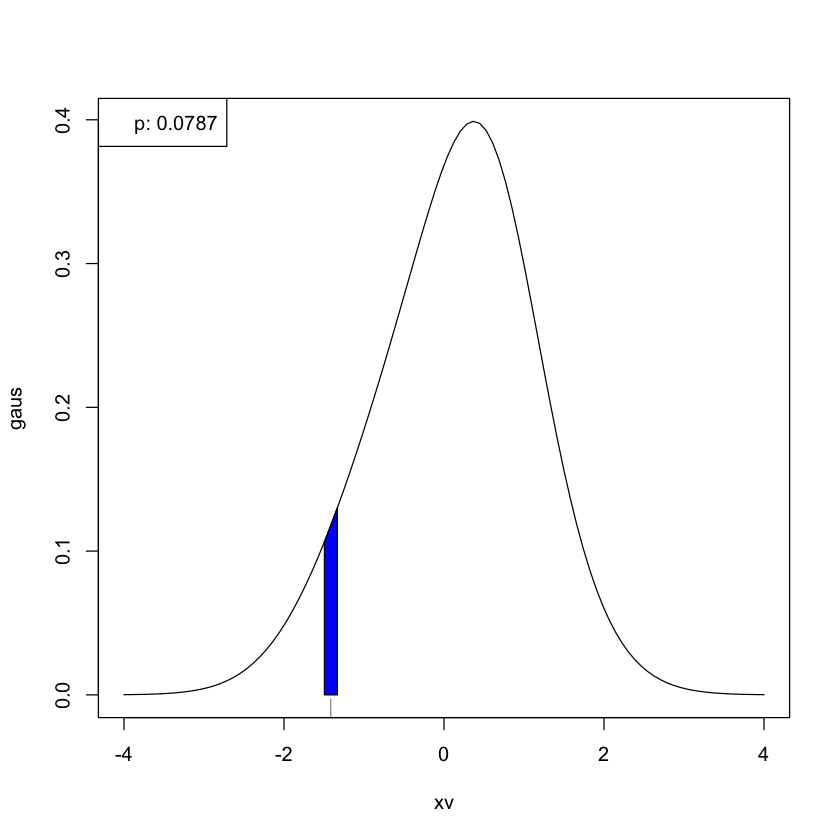

In [50]:
xv <- seq(-4, 4, length=100)
i <- xv[33]
gaus <- dnorm(xv, dnorm(xv))
plot(xv, gaus, type='l')
polygon(xv[c(32:34, 34:32)], c(gaus[32:34], rep(0, 3)), col=4)
rug(i)
p <- pnorm(i)
legend('topleft', legend=sprintf('p: %.4f', p))

In [51]:
assign.likelihoods <- function(clust, best.params) {
  pad <- 0.000001 # integrate over region [x - pad, x + pad]
  mus <- best.params$mus
  sigmas <- best.params$sigmas
  ks <- length(mus)
  n <- nrow(clust)
  all.ps <- matrix(nrow=n, ncol=ks)
  for (i in 1:n) {
    ps <- numeric()
    for (k in 1:ks) {
      # Determine the probabilities of each point under each distribution
      x <- clust$x[i]
      p.left <- pnorm(x - pad, mean=mus[k], sd=sigmas[k])
      p.right <- pnorm(x + pad, mean=mus[k], sd=sigmas[k])
      p <- p.right - p.left
      ps[k] <- p
    }
    # Assign x to the cluster with the highest probability
    clust[i, 'assignments'] <- which(ps == max(ps))
    all.ps[i, ] <- ps
  }
  for (k in 1:ks) {
    clust[, sprintf('p_k%d', k)] <- all.ps[, k]      
  }
  clust
}

In [52]:
clust <- assign.likelihoods(clust, best.params)
head(clust)

,x,k,assignments,p_k1,p_k2,p_k3
997,-5.461411,2,3,1.263937e-10,1.770688e-139,2.878935e-09
785,-5.197476,2,3,3.162091e-10,2.755172e-129,3.523352e-09
925,-4.440322,2,3,3.295348e-09,2.677775e-102,6.121881e-09
797,-4.157585,2,3,7.090112e-09,4.463248e-93,7.447649e-09
575,-4.133210,2,3,7.553270e-09,2.647982e-92,7.572607e-09
535,-3.749063,2,1,1.931756e-08,1.419817e-80,9.789154e-09


In [53]:
table(clust$assignments)


  1   2   3 
418 547 346 

$mus
[1] -0.6450388  1.3900570  6.5183587

$sigmas
[1] 1.0695366 0.3427622 3.8624017

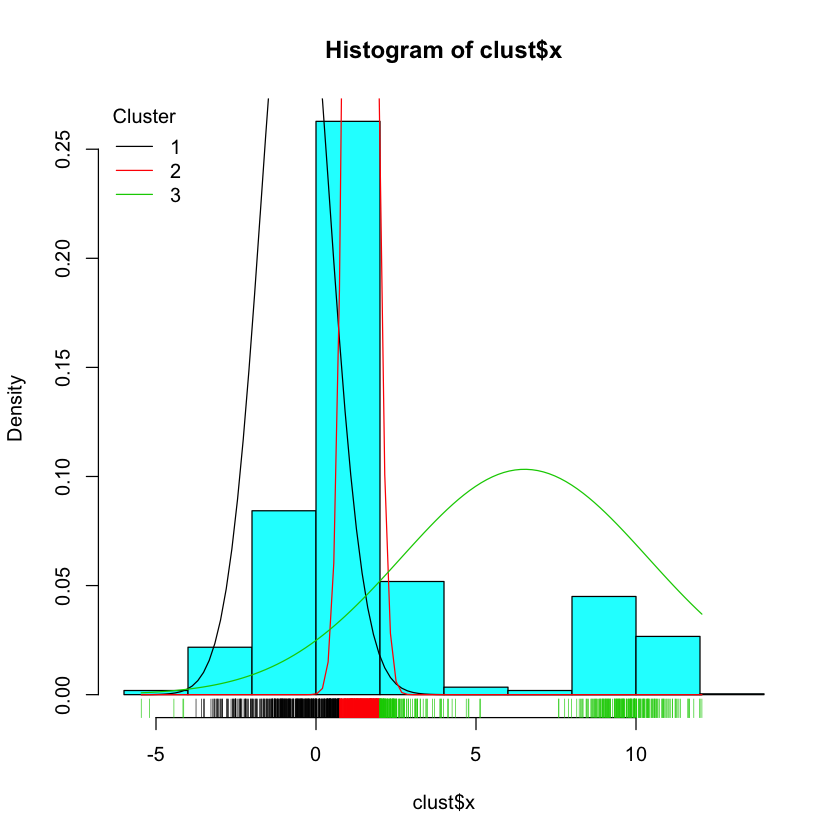

In [54]:
best.params <- get.params.from.assignments(clust)
best.params

In [55]:
clust <- assign.likelihoods(clust, best.params)
head(clust)
table(clust$assignments)

,x,k,assignments,p_k1,p_k2,p_k3
997,-5.461411,2,3,2.945730e-11,4.015117e-93,1.683033e-09
785,-5.197476,2,3,8.681465e-11,1.444054e-86,2.075518e-09
925,-4.440322,2,3,1.375345e-09,3.448756e-69,3.689981e-09
797,-4.157585,2,3,3.393397e-09,3.044765e-63,4.529613e-09
575,-4.133210,2,3,3.656189e-09,9.601441e-63,4.609230e-09
535,-3.749063,2,1,1.105978e-08,3.570755e-55,6.033914e-09



  1   2   3 
409 609 293 

$mus
[1] -0.6751957  1.4413291  7.3190195

$sigmas
[1] 1.0615078 0.3908476 3.6641136

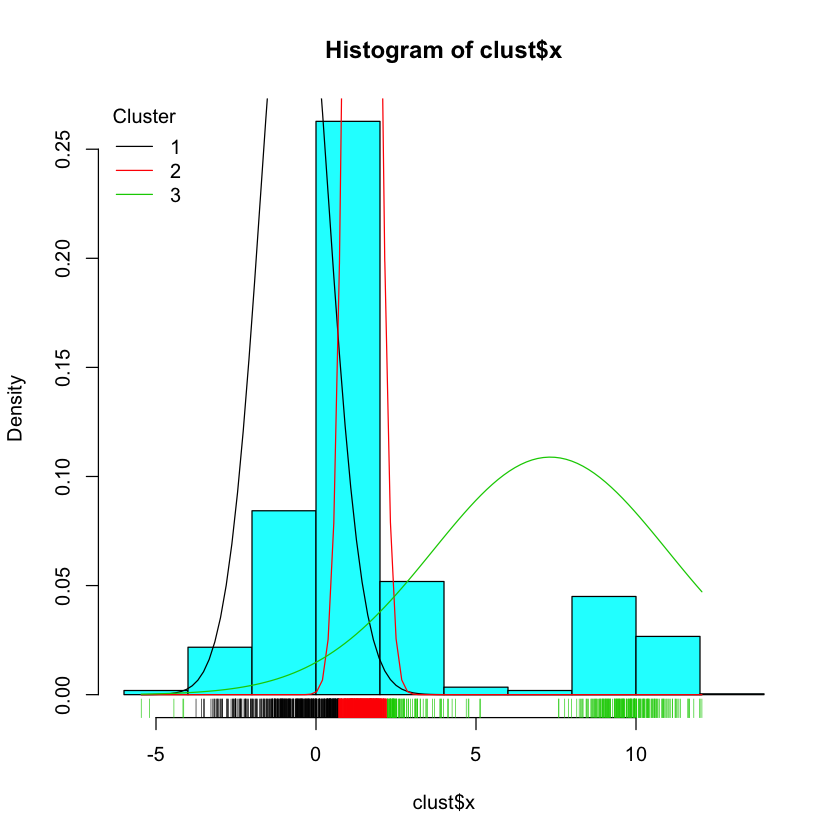

In [56]:
best.params <- get.params.from.assignments(clust)
best.params

In [57]:
clust <- assign.likelihoods(clust, best.params)
head(clust)
table(clust$assignments)

,x,k,assignments,p_k1,p_k2,p_k3
997,-5.461411,2,3,2.893387e-11,3.799571e-74,4.967361e-10
785,-5.197476,2,3,8.607290e-11,4.572968e-69,6.369640e-10
925,-4.440322,2,1,1.393487e-09,1.366702e-55,1.262994e-09
797,-4.157585,2,1,3.459357e-09,5.620110e-51,1.613090e-09
575,-4.133210,2,1,3.729048e-09,1.370569e-50,1.647018e-09
535,-3.749063,2,1,1.135403e-08,1.035493e-44,2.273113e-09



  1   2   3 
404 646 261 

$mus
[1] -0.7289794  1.4722179  8.0059078

$sigmas
[1] 1.0932202 0.4309529 3.2075765

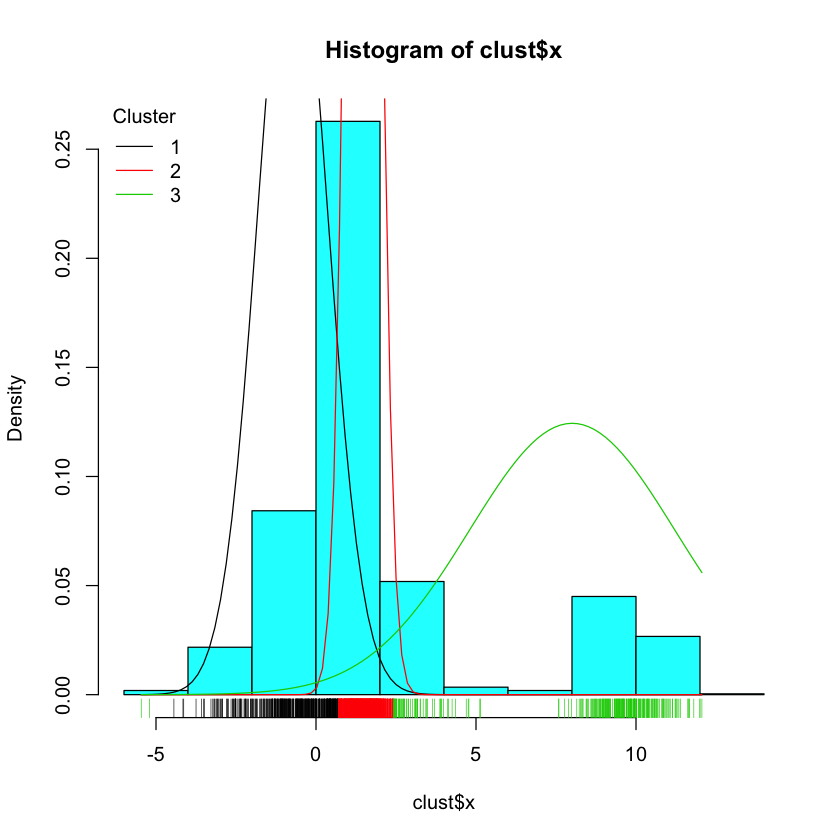

In [58]:
best.params <- get.params.from.assignments(clust)
best.params

In [59]:
clust <- assign.likelihoods(clust, best.params)
head(clust)
table(clust$assignments)

,x,k,assignments,p_k1,p_k2,p_k3
997,-5.461411,2,1,6.223656e-11,1.140785e-62,3.696970e-11
785,-5.197476,2,1,1.719004e-10,1.799440e-58,5.204939e-11
925,-4.440322,2,1,2.293914e-09,2.476884e-47,1.337532e-10
797,-4.157585,2,1,5.337841e-09,1.620214e-43,1.875681e-10
575,-4.133210,2,1,5.723053e-09,3.386751e-43,1.930466e-10
535,-3.749063,2,1,1.607034e-08,2.469482e-38,3.015699e-10



  1   2   3 
399 670 242 

In [60]:
ADDITIONAL_ITERS <- 10
for (i in 1:ADDITIONAL_ITERS) {
  best.params <- get.params.from.assignments(clust, plt=F)
  clust <- assign.likelihoods(clust, best.params) 
}

head(clust)
table(clust$assignments)

,x,k,assignments,p_k1,p_k2,p_k3
997,-5.461411,2,1,1.346172e-10,4.638379e-41,8.529843e-22
785,-5.197476,2,1,3.498110e-10,1.672915e-38,2.836766e-21
925,-4.440322,2,1,3.961546e-09,1.029603e-31,7.901037e-20
797,-4.157585,2,1,8.706539e-09,2.188158e-29,2.614223e-19
575,-4.133210,2,1,9.289982e-09,3.431174e-29,2.894932e-19
535,-3.749063,2,1,2.423230e-08,3.186617e-26,1.409603e-18



  1   2   3 
377 724 210 

In [61]:
# Assign colors relative to degree of ownership by each cluster
colors <- character(nrow(clust))
for (i in 1:nrow(clust)) {
  b <- clust[i, 'p_k1']
  r <- clust[i, 'p_k2']
  g <- clust[i, 'p_k3']
  tot <- r + g + b
  colors[i] <- rgb(r/tot, g/tot, b/tot)
}
clust$colors <- colors
tail(clust)

,x,k,assignments,p_k1,p_k2,p_k3,colors
1188,11.65627,3,3,0,0,1.864621e-07,#00FF00
1145,11.67658,3,3,0,0,1.836835e-07,#00FF00
1202,11.80670,3,3,0,0,1.663274e-07,#00FF00
1173,11.99670,3,3,0,0,1.425293e-07,#00FF00
1183,11.99994,3,3,0,0,1.421410e-07,#00FF00
1223,12.05938,3,3,0,0,1.351169e-07,#00FF00


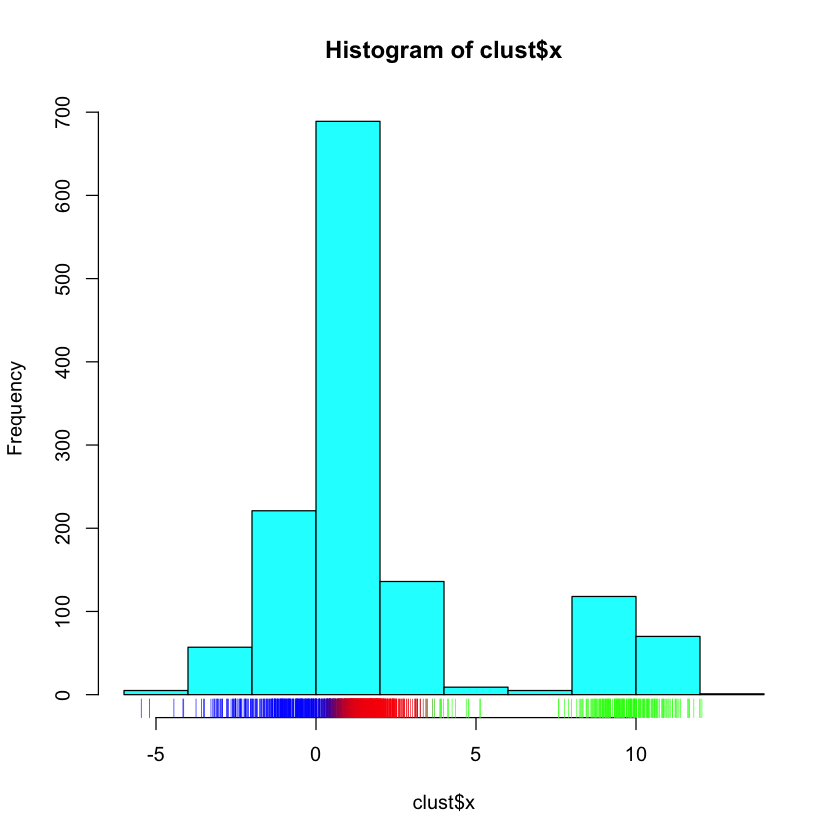

In [62]:
hist(clust$x, col=5)
for (i in 1:nrow(clust)) {
  rug(clust[i, 'x'], col=clust[i, 'colors'])   
}

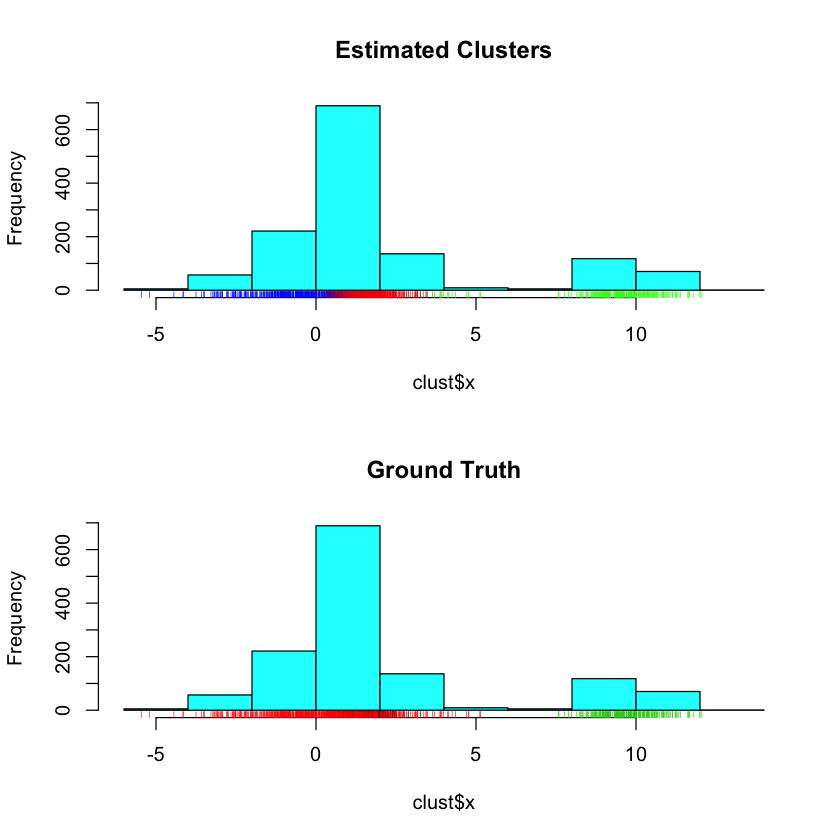

In [63]:
# Compare again with ground truth
par(mfrow=c(2, 1))
hist(clust$x, col=5, main='Estimated Clusters')
for (i in 1:nrow(clust)) {
  rug(clust[i, 'x'], col=clust[i, 'colors'])   
}

hist(clust$x, col=5, main='Ground Truth')
for (i in 1:K) {
  rug(clust[clust$k == i, 'x'], col=i)
}

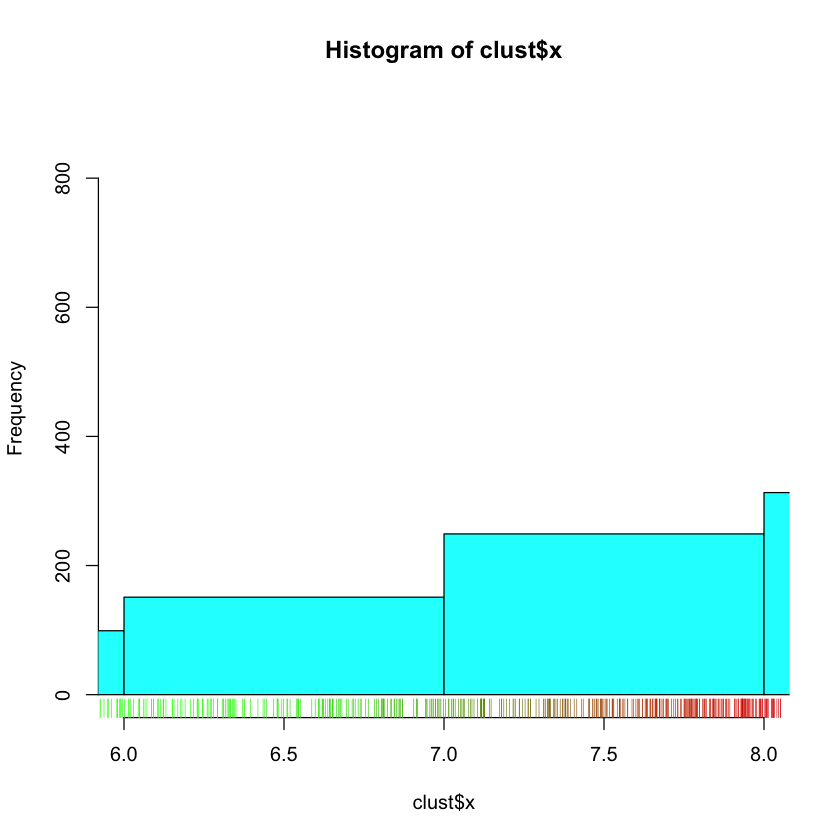

In [32]:
# Zoom in to see color gradient better in areas of high uncertainty
hist(clust$x, col=5, xlim=c(6, 8)) # <- vary xlim range as needed

# You will get a warning if you use rug and a point lies outside the
# visible range of the graph.  Use "warn" options to silence the warnings
options(warn=-1)
for (i in 1:nrow(clust)) {
  rug(clust[i, 'x'], col=clust[i, 'colors'])   
}
options(warn=0)